# Introduction

Thie notebook applies causal forests to estimate the CATE on the Peyton 2019 dataaset.

# Dependencies

Note that this notebook was run on google collab.

In [1]:
%%capture
!pip install econml

In [2]:
# Models
import statsmodels.formula.api as smf
from patsy.contrasts import Treatment
from econml.grf import CausalForest
from econml.dml import CausalForestDML

# Data prep
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

# General
import numpy as np
import pandas as pd
import scipy.stats as st

# Dataset

Information on the [Peyton experiment](https://isps.yale.edu/research/data/d152) and details about the [data preparation](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1910157116&file=pnas.1910157116.sapp.pdf)

Our variables will be:
* features X:
  * dem_age
  * dem_female
  * dem_race4
  * dem_pid?
  * dem_inc_high
  * contact_arrest_t0
  * contact_unfair_t0
  * contact_f2f_t0
  * spanish
* Z = treatment assignemnt
* D = treatment receipt
* Y = primary_dv_index_t1

In [3]:
# Load dataset
data = pd.read_csv("/content/cops_df.csv")
data.head(3)

print(data.shape)

(49757, 237)


In [4]:
data.columns[0:10]

Index(['pid', 'hh_id', 'Z', 'D', 'R_t0', 'R_t1', 'R_t2', 'itrust_care_t0',
       'itrust_care_t1', 'itrust_care_t2'],
      dtype='object')

In [5]:
# Only include those that complied
data_filtered = data.dropna()

In [6]:
data_filtered.shape

(1069, 237)

In [7]:
data.where(data['R_t0'] == 1).groupby(['Z', 'D']).count()

pid  hh_id  R_t0  R_t1  R_t2  itrust_care_t0  itrust_care_t1  \
Z   D                                                                    
0.0 0.0  1006   1006  1006  1006   735            1006             735   
1.0 0.0   595    595   595   595   439             595             439   
    1.0   412    412   412   412   310             412             310   

         itrust_care_t2  fair_decision_t0  fair_decision_t1  ...  \
Z   D                                                        ...   
0.0 0.0             523              1006               735  ...   
1.0 0.0             324               595               439  ...   
    1.0             222               412               310  ...   

         perform_index_t1  perform_index_t2  primary_dvs_index_t0  \
Z   D                                                               
0.0 0.0               735               523                  1006   
1.0 0.0               439               324                   595   
    1.0               310               222                   412   

         primary_dvs_index_t1  primary_dvs_index_t2  csi_index_t0  \
Z   D                                                               
0.0 0.0                   735                   523          1006   
1.0 0.0                   439                   324           595   
    1.0                   310                   222           412   

         csi_index_t1  csi_index_t2  trustgov_local_index_t0  \
Z   D                                                          
0.0 0.0           735           523                     1006   
1.0 0.0           439           324                      595   
    1.0           310           222                      412   

         trustgov_local_index_t1  
Z   D                             
0.0 0.0                      735  
1.0 0.0                      439  
    1.0                      310  

[3 rows x 235 columns]

In [8]:
data_filtered.where(data_filtered['R_t0'] == 1).groupby(['Z', 'D']).count()

pid  hh_id  R_t0  R_t1  R_t2  itrust_care_t0  itrust_care_t1  \
Z   D                                                                   
0.0 0.0  523    523   523   523   523             523             523   
1.0 0.0  324    324   324   324   324             324             324   
    1.0  222    222   222   222   222             222             222   

         itrust_care_t2  fair_decision_t0  fair_decision_t1  ...  \
Z   D                                                        ...   
0.0 0.0             523               523               523  ...   
1.0 0.0             324               324               324  ...   
    1.0             222               222               222  ...   

         perform_index_t1  perform_index_t2  primary_dvs_index_t0  \
Z   D                                                               
0.0 0.0               523               523                   523   
1.0 0.0               324               324                   324   
    1.0               222               222                   222   

         primary_dvs_index_t1  primary_dvs_index_t2  csi_index_t0  \
Z   D                                                               
0.0 0.0                   523                   523           523   
1.0 0.0                   324                   324           324   
    1.0                   222                   222           222   

         csi_index_t1  csi_index_t2  trustgov_local_index_t0  \
Z   D                                                          
0.0 0.0           523           523                      523   
1.0 0.0           324           324                      324   
    1.0           222           222                      222   

         trustgov_local_index_t1  
Z   D                             
0.0 0.0                      523  
1.0 0.0                      324  
    1.0                      222  

[3 rows x 235 columns]

In [9]:
# primary_dvs = ["coop_index", "comply_index", "legit_index",
#                  "perform_index", "primary_dvs_index"]

covariates = ["dem_age", "dem_female", "dem_race4", "dem_pid7", "dem_inc_high", 
              "contact_arrest_t0", "contact_unfair_t0", "contact_f2f_t0", "spanish"]

# OLS

Use OLS to get the treatment effect on the primary dvs index for t1 and t2
* ITT:  $ y = b_0 + Z + covariates$


In [18]:
# For intent to treat (ITT) 

# Define the variables
Y_col = "primary_dvs_index_t1"
X_col = ["primary_dvs_index_t0"] + covariates

# Define formula
X_str = " + ".join(X_col)
formula = f"{Y_col} ~ Z + {X_str}"

# Model
model = smf.ols(formula=formula, data=data).fit() # There might be an option to use robust standard errors
model = model.get_robustcov_results(cov_type='HC1', use_t=None)
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     primary_dvs_index_t1   R-squared:                       0.761
Model:                              OLS   Adj. R-squared:                  0.759
Method:                   Least Squares   F-statistic:                     364.6
Date:                  Sun, 29 Jan 2023   Prob (F-statistic):               0.00
Time:                          14:43:26   Log-Likelihood:                -5199.9
No. Observations:                  1484   AIC:                         1.043e+04
Df Residuals:                      1470   BIC:                         1.050e+04
Df Model:                            13                                         
Covariance Type:                    HC1                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept 

Results are same as paper.

In [19]:
# The causal tree doesn't handle null values so excluding them for simplicity and re-run ITT

# Define the variables
Y_col = "primary_dvs_index_t1"
X_col = ["primary_dvs_index_t0"] + covariates

# Define formula
X_str = " + ".join(X_col)
formula = f"{Y_col} ~ Z + {X_str}"

# Model
model = smf.ols(formula=formula, data=data_filtered).fit()
model = model.get_robustcov_results(cov_type='HC1', use_t=None)
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     primary_dvs_index_t1   R-squared:                       0.768
Model:                              OLS   Adj. R-squared:                  0.766
Method:                   Least Squares   F-statistic:                     278.7
Date:                  Sun, 29 Jan 2023   Prob (F-statistic):               0.00
Time:                          14:43:48   Log-Likelihood:                -3730.1
No. Observations:                  1069   AIC:                             7488.
Df Residuals:                      1055   BIC:                             7558.
Df Model:                            13                                         
Covariance Type:                    HC1                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept 

# Causal Forest

Uses the econml.grf CausalForest: [documentation](https://econml.azurewebsites.net/_autosummary/econml.grf.CausalForest.html) and [example](https://github.com/microsoft/EconML/blob/main/notebooks/Generalized%20Random%20Forests.ipynb)


In [20]:
# Encode categorical variables
data_filtered.loc[:,'dem_race4_encoded'] = data_filtered["dem_race4"].map({'White': 0, 'Other': 1, 'Black': 2, 'Hispanic': 3})


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
X_col = [
  'primary_dvs_index_t0',
  'dem_age',
  'dem_female',
  'dem_race4_encoded',
  'dem_pid7',
  'dem_inc_high',
  'contact_arrest_t0',
  'contact_unfair_t0',
  'contact_f2f_t0',
  'spanish']

In [26]:
# Split features, outcome, treatment
X = np.array(data_filtered[X_col])
y = np.array(data_filtered[Y_col])
T = np.array(data_filtered['Z'])

In [27]:
est = CausalForest(criterion='het', 
                   n_estimators=1000, 
                   min_samples_leaf=5, 
                   max_depth=10, # Kept short trees
                   min_var_fraction_leaf=None, 
                   min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, 
                   max_samples=0.45, 
                   min_balancedness_tol=.45,
                   warm_start=False, 
                   inference=True, 
                   fit_intercept=True, 
                   subforest_size=4,
                   honest=True, 
                   verbose=0, 
                   n_jobs=-1, 
                   random_state=1235)

In [28]:
%%time
est.fit(X, T, y)


CPU times: user 2.09 s, sys: 50.3 ms, total: 2.14 s
Wall time: 2.67 s


CausalForest(criterion='het', max_depth=10, min_var_leaf_on_val=True,
             n_estimators=1000, random_state=1235)

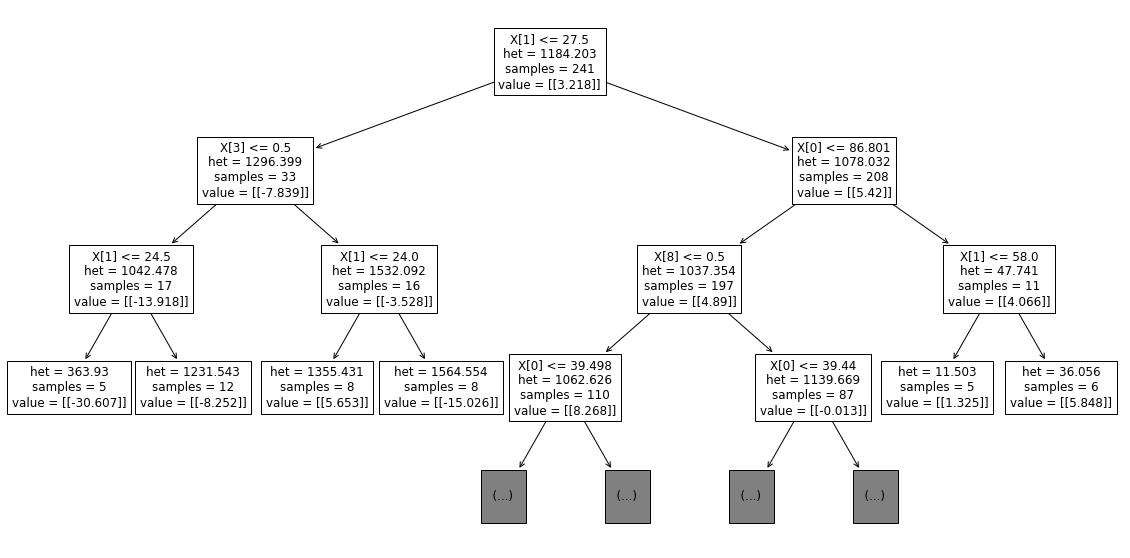

In [29]:
# Display causal tree:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=3)
plt.show()

Observations:
* het = the heterogeneity score for the splitting criterion
* value = treatment effect

* check with the paper whether high dv_index was a worse view or a better view?



## Feature Importance


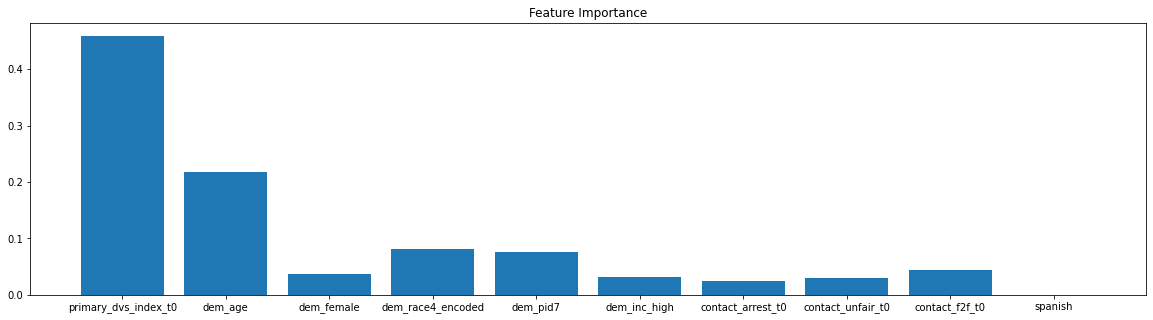

In [30]:
plt.figure(figsize=(20,5))
plt.bar(x=X_col, height=est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.title("Feature Importance")
plt.show()

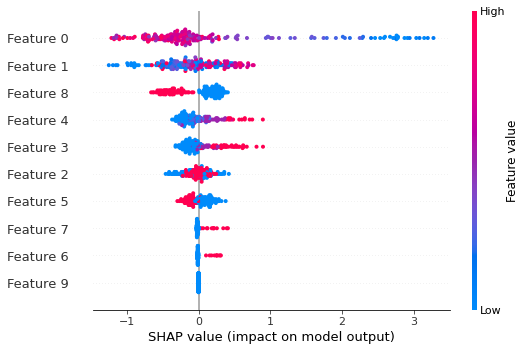

In [32]:
import shap
explainer = shap.Explainer(est, shap.maskers.Independent(X, max_samples=100))
shap_values = explainer(X[:200])

shap.plots.beeswarm(shap_values[:, :])

## Individual treatment effects

In [45]:
# Estimated treatment effect for each individual
point, lb, ub = est.predict(X, interval=True, alpha=0.01)

print(np.mean(point))
print(st.t.interval(0.95, len(point)-1, loc=np.mean(point), scale=st.sem(point)))

2.295866466649345
(array([2.21262041]), array([2.37911252]))


average treatment effect is similar to one from OLS and is statistically significant at 95%.

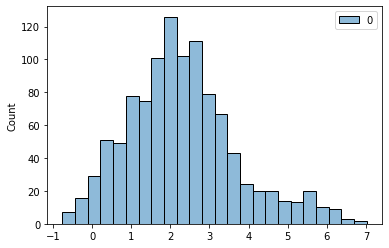

In [46]:
sns.histplot(point)

In [47]:
# Gather estimate and ci into dataframe
cate_df = pd.DataFrame({'cate': point[:,0], 'lb': lb[:, 0], 'ub': ub[:,0]})

cate_df = (
    cate_df
      .sort_values(by=["cate"], ascending=True)
      .reset_index(drop=True)
)

# Rolling mean is to smooth the data for plotting
cate_df['rolling_cate'] = cate_df['cate'].rolling(window=100, center=True).mean()

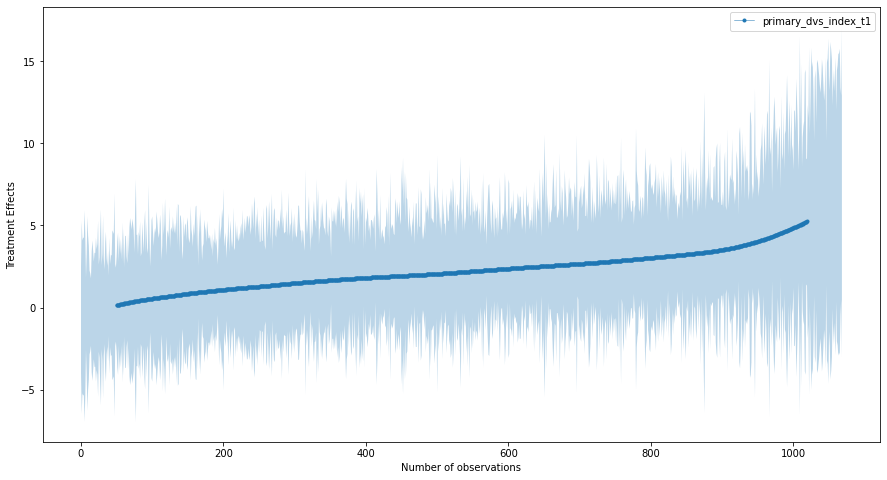

In [48]:
# Plot results
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(
    cate_df['rolling_cate'],
    marker='.', linestyle='-', linewidth=0.5, label='primary_dvs_index_t1'
)
ax.fill_between(x=range(len(cate_df['rolling_cate'])), y1=cate_df['lb'], y2=cate_df['ub'], alpha=0.3)

ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

The observations are ordered by their treatment effects from smallest to largest.  

## Partial effects


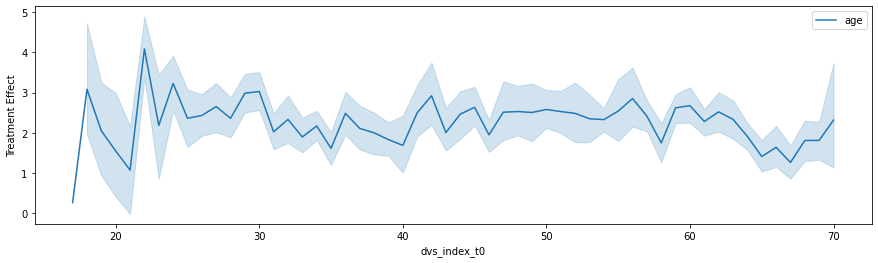

In [49]:
# Treatment effect vs dvs_index_t0
fig, ax = plt.subplots(figsize=(15, 4))

g = sns.lineplot(x=X[:, 1], y=point[:, 0], label='age', estimator='mean', ci=95)

plt.ylabel("Treatment Effect")
plt.xlabel("dvs_index_t0")
plt.legend()
plt.show()

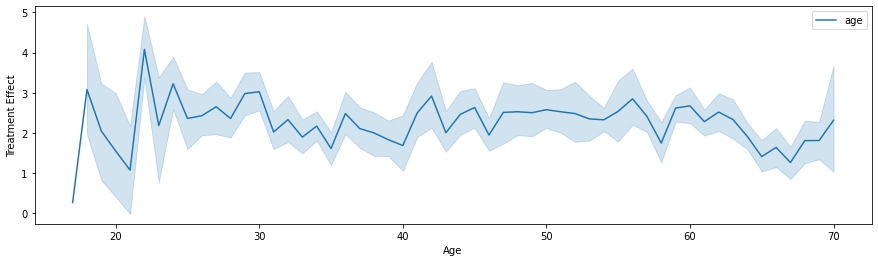

In [50]:
# Treatment effect vs age
fig, ax = plt.subplots(figsize=(15, 4))

g = sns.lineplot(x=X[:, 1], y=point[:, 0], label='age', estimator='mean', ci=95)

plt.ylabel("Treatment Effect")
plt.xlabel("Age")
plt.legend()
plt.show()

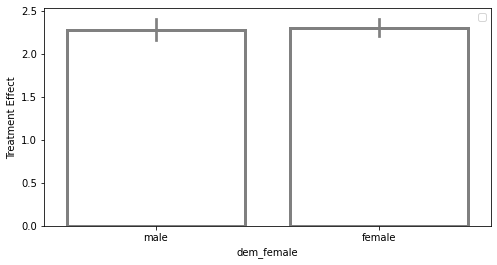

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))

g = sns.barplot(x=X[:, 2], y=point[:, 0],
                errcolor=".5", linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))

g.set_xticklabels(['male', 'female'])
plt.ylabel("Treatment Effect")
plt.xlabel("dem_female")
plt.legend()
plt.show()

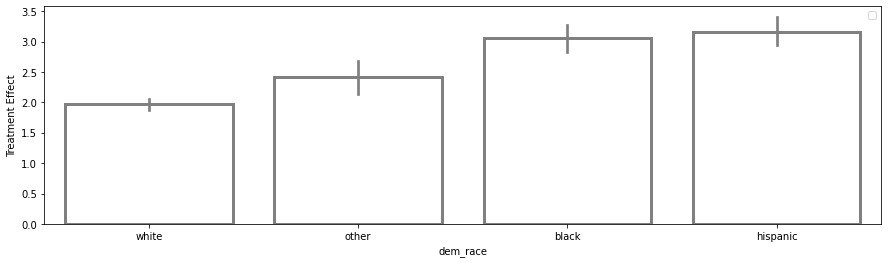

In [52]:
# 'White': 0, 'Other': 1, 'Black': 2, 'Hispanic': 3}
fig, ax = plt.subplots(figsize=(15, 4))

g = sns.barplot(x=X[:, 3], y=point[:, 0],
                errcolor=".5", linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))

g.set_xticklabels(['white', 'other', 'black', 'hispanic'])
plt.ylabel("Treatment Effect")
plt.xlabel("dem_race")
plt.legend()
plt.show()

do contour plots of different 

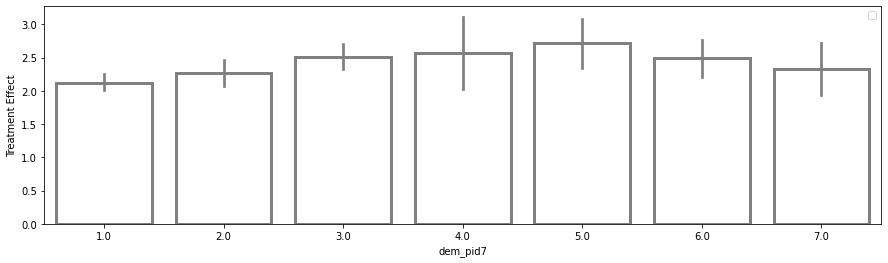

In [53]:
# 'White': 0, 'Other': 1, 'Black': 2, 'Hispanic': 3}
fig, ax = plt.subplots(figsize=(15, 4))

g = sns.barplot(x=X[:, 4], y=point[:, 0],
                errcolor=".5", linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))

plt.ylabel("Treatment Effect")
plt.xlabel("dem_pid7")
plt.legend()
plt.show()

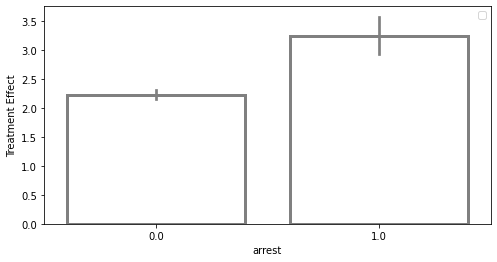

In [54]:
fig, ax = plt.subplots(figsize=(8, 4))

g = sns.barplot(x=X[:, 6], y=point[:, 0],
                errcolor=".5", linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))

plt.ylabel("Treatment Effect")
plt.xlabel("arrest")
plt.legend()
plt.show()

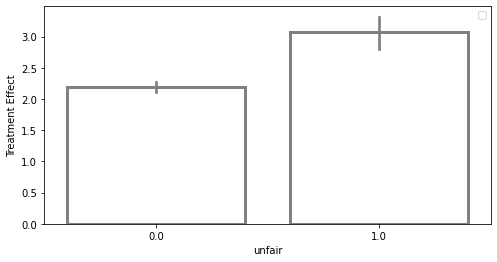

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))

g = sns.barplot(x=X[:, 7], y=point[:, 0],
                errcolor=".5", linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))

plt.ylabel("Treatment Effect")
plt.xlabel("unfair")
plt.legend()
plt.show()

Statistically significant treatment for gender, race, party, arrest and unfair.  Larger effect for blacks and hispanice, and those who had arrest and unfair in t0.

# End